# Pre-2004 Wildfire Prediction Using LSTM
- We will use LSTM to predict the **number of wildfires per day** and the **average fire size** in California. The model will use environmental data such as **temperature** and **precipitation** to improve accuracy.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [68]:
df = pd.read_csv('pre_2004_data.csv')
df

,DiscoveryDate,DiscoveryDayOfYear,DiscoveryTime,ContainmentDate,ContainmentDayOfYear,ContainmentTime,FireSize,FireSizeClass,Latitude,Longitude,CauseClassification,GeneralCause,MinTemperature,MaxTemperature,AvgTemperature,Precipitation,Snowfall
0,1992-01-01,1,01:30,1992-01-01,1.0,02:10,0.1,A,38.205000,-120.335000,Natural,Natural,3.89,13.89,8.89,0.00,0.0
1,1992-01-01,1,13:30,1992-01-01,1.0,17:00,5.0,B,33.166700,-116.634200,Human,Debris and open burning,-1.67,12.78,5.56,0.00,0.0
2,1992-01-01,1,14:37,1992-01-01,1.0,15:07,0.2,A,33.663889,-116.171944,Human,Misuse of fire by a minor,-1.67,12.78,5.56,0.00,0.0
3,1992-01-02,2,14:37,1992-01-02,2.0,15:07,0.2,A,33.030000,-116.831944,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
4,1992-01-02,2,14:37,1992-01-02,2.0,15:17,0.5,B,33.896111,-116.990000,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96831,2003-12-29,363,07:41,2003-12-29,363.0,08:00,0.1,A,34.140000,-117.150000,Human,Power generation/transmission/distribution,-1.67,9.44,3.89,0.00,0.0
96832,2003-12-29,363,21:40,2003-12-29,363.0,22:30,0.1,A,34.381944,-118.097222,Human,Arson/incendiarism,-1.67,9.44,3.89,0.00,0.0
96833,2003-12-31,365,15:58,2003-12-31,365.0,16:31,0.2,A,33.968056,-117.515000,Human,Equipment and vehicle use,0.56,12.78,6.67,0.00,0.0
96834,2003-12-31,365,16:53,2003-12-31,365.0,17:02,0.1,A,38.185000,-120.371389,Human,Debris and open burning,3.89,11.11,7.50,0.51,0.0


In [69]:
# Select relevant columns for  prediction
df_selected = df[['DiscoveryDate', 'FireSize', 'MaxTemperature', 'Precipitation']]
df_selected.head()

,DiscoveryDate,FireSize,MaxTemperature,Precipitation
0,1992-01-01,0.1,13.89,0.0
1,1992-01-01,5.0,12.78,0.0
2,1992-01-01,0.2,12.78,0.0
3,1992-01-02,0.2,12.22,0.0
4,1992-01-02,0.5,12.22,0.0


### Plot FireSize, MaxTemperature, and Precipitation

In [70]:
df_selected = df_selected.copy()
df_selected['DiscoveryDate'] = pd.to_datetime(df_selected['DiscoveryDate'], errors='coerce')

df_selected.set_index('DiscoveryDate', inplace=True)

Text(0, 0.5, 'Fire Size')

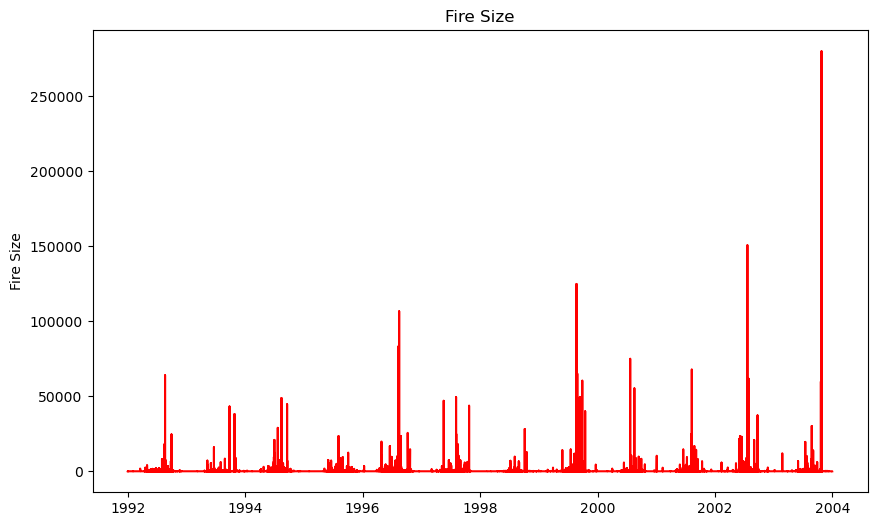

In [71]:
# Fire Size
plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['FireSize'], label='Fire Size', color='red')
plt.title('Fire Size')
plt.ylabel('Fire Size')

Text(0, 0.5, 'Max Temperature (°C)')

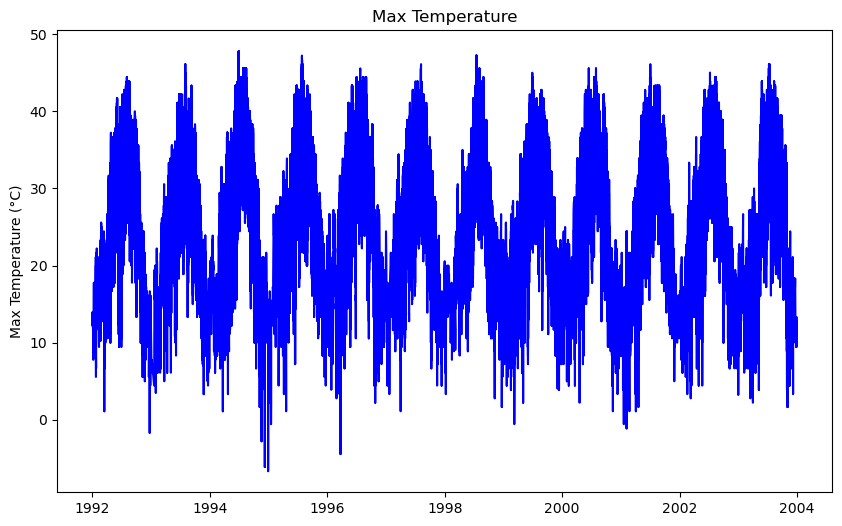

In [72]:
# Max Temperature
plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['MaxTemperature'], label='Max Temperature', color='blue')
plt.title('Max Temperature')
plt.ylabel('Max Temperature (°C)')

Text(0, 0.5, 'Precipitation (mm)')

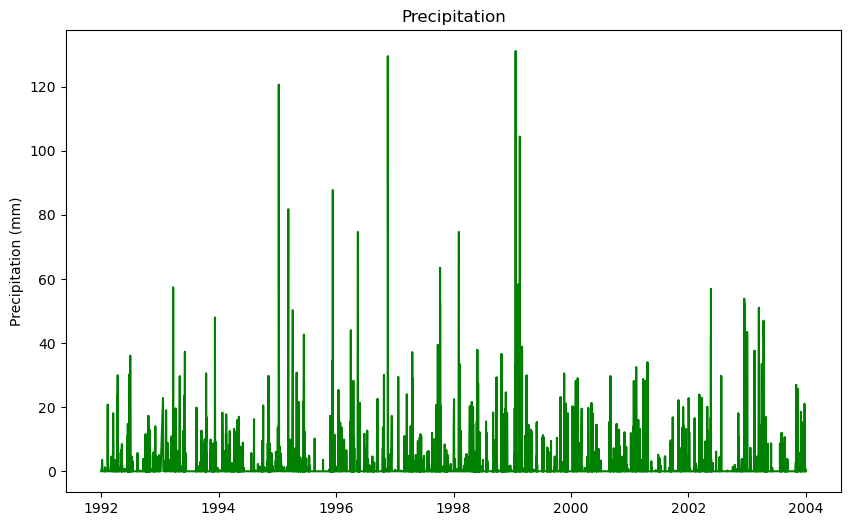

In [73]:
# Precipitation
plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['Precipitation'], label='Precipitation', color='green')
plt.title('Precipitation')
plt.ylabel('Precipitation (mm)')

## Number of Wildfires per Day Prediction

In [74]:
# Group by DiscoveryDate and count the number of fires, average environmental factors
df_aggregated = df_selected.groupby('DiscoveryDate').agg({
    'FireSize': 'count', 
    'MaxTemperature': 'mean',
    'Precipitation': 'mean'
}).rename(columns={'FireSize': 'NumberOfFires'})  

df_aggregated

,NumberOfFires,MaxTemperature,Precipitation
DiscoveryDate,,,
1992-01-01,3,13.150000,0.00
1992-01-02,3,12.220000,0.00
1992-01-03,1,13.890000,0.00
1992-01-04,2,12.220000,0.00
1992-01-06,1,11.670000,1.78
...,...,...,...
2003-12-24,1,13.330000,21.08
2003-12-27,1,13.330000,0.00
2003-12-28,3,10.736667,0.00


#### Set the Frequency to Daily and Fill Missing Data

In [77]:
# Set the frequency of the dataframe to daily
df_aggregated = df_aggregated.asfreq('D')

# Fill missing NumberOfFires with 0
df_aggregated['NumberOfFires'].fillna(0, inplace=True)

# Handle missing environmental variables with interpolation
df_aggregated.loc[:, ['MaxTemperature', 'Precipitation']] = df_aggregated.loc[:, ['MaxTemperature', 'Precipitation']].interpolate(method='linear')

df_aggregated

,NumberOfFires,MaxTemperature,Precipitation
DiscoveryDate,,,
1992-01-01,3.0,13.150000,0.000
1992-01-02,3.0,12.220000,0.000
1992-01-03,1.0,13.890000,0.000
1992-01-04,2.0,12.220000,0.000
1992-01-05,0.0,11.945000,0.890
...,...,...,...
2003-12-27,1.0,13.330000,0.000
2003-12-28,3.0,10.736667,0.000
2003-12-29,3.0,9.440000,0.000


(array([ 7670.,  8035.,  8401.,  8766.,  9131.,  9496.,  9862., 10227.,
        10592., 10957., 11323., 11688., 12053., 12418.]),
 [Text(7670.0, 0, '1991'),
  Text(8035.0, 0, '1992'),
  Text(8401.0, 0, '1993'),
  Text(8766.0, 0, '1994'),
  Text(9131.0, 0, '1995'),
  Text(9496.0, 0, '1996'),
  Text(9862.0, 0, '1997'),
  Text(10227.0, 0, '1998'),
  Text(10592.0, 0, '1999'),
  Text(10957.0, 0, '2000'),
  Text(11323.0, 0, '2001'),
  Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004')])

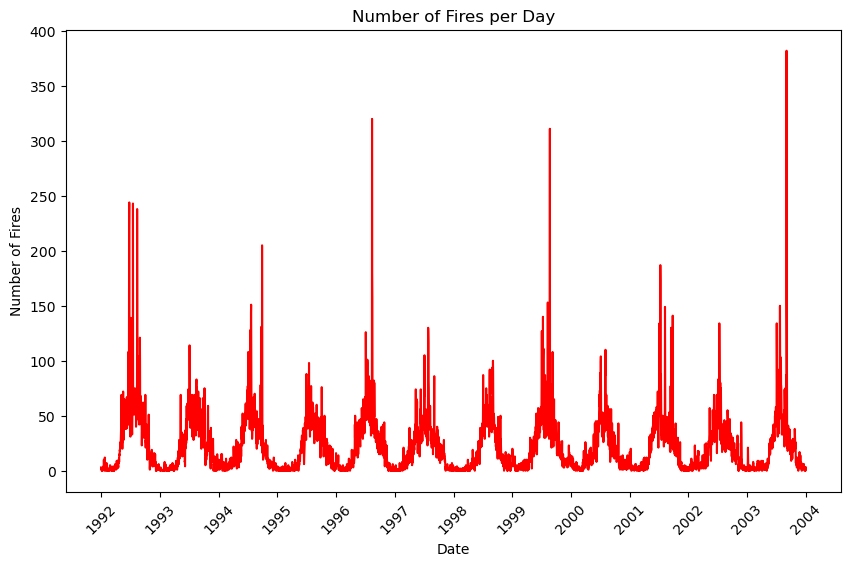

In [78]:
# Plot Number of Fires per day
plt.figure(figsize=(10, 6))
plt.plot(df_aggregated.index, df_aggregated['NumberOfFires'], label='Number of Fires', color='red')
plt.title('Number of Fires per Day')
plt.ylabel('Number of Fires')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

(array([ 7670.,  8035.,  8401.,  8766.,  9131.,  9496.,  9862., 10227.,
        10592., 10957., 11323., 11688., 12053., 12418.]),
 [Text(7670.0, 0, '1991'),
  Text(8035.0, 0, '1992'),
  Text(8401.0, 0, '1993'),
  Text(8766.0, 0, '1994'),
  Text(9131.0, 0, '1995'),
  Text(9496.0, 0, '1996'),
  Text(9862.0, 0, '1997'),
  Text(10227.0, 0, '1998'),
  Text(10592.0, 0, '1999'),
  Text(10957.0, 0, '2000'),
  Text(11323.0, 0, '2001'),
  Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004')])

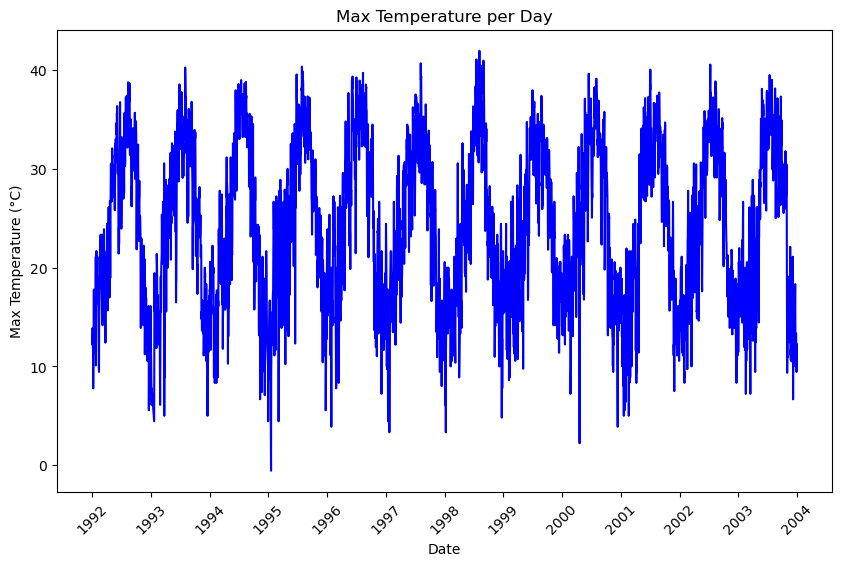

In [79]:
# Plot Max Temperature per day
plt.figure(figsize=(10, 6))
plt.plot(df_aggregated.index, df_aggregated['MaxTemperature'], label='Max Temperature', color='blue')
plt.title('Max Temperature per Day')
plt.ylabel('Max Temperature (°C)')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.xticks(rotation=45)

(array([ 7670.,  8035.,  8401.,  8766.,  9131.,  9496.,  9862., 10227.,
        10592., 10957., 11323., 11688., 12053., 12418.]),
 [Text(7670.0, 0, '1991'),
  Text(8035.0, 0, '1992'),
  Text(8401.0, 0, '1993'),
  Text(8766.0, 0, '1994'),
  Text(9131.0, 0, '1995'),
  Text(9496.0, 0, '1996'),
  Text(9862.0, 0, '1997'),
  Text(10227.0, 0, '1998'),
  Text(10592.0, 0, '1999'),
  Text(10957.0, 0, '2000'),
  Text(11323.0, 0, '2001'),
  Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004')])

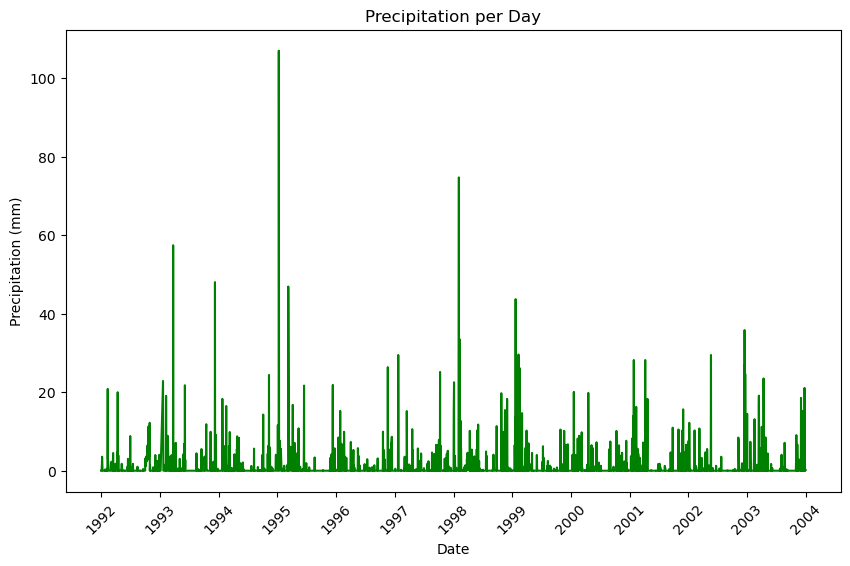

In [80]:
# Plot Precipitation per day
plt.figure(figsize=(10, 6))
plt.plot(df_aggregated.index, df_aggregated['Precipitation'], label='Precipitation', color='green')
plt.title('Precipitation per Day')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)